# KNN regression

In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde


## Read the etl info results

In [46]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,True,False,False,Lasso,False


## Read the dataset

In [47]:
df = pd.read_csv('../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,hMean,hSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,105.368375,41.572939
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,112.399458,41.795584
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,114.021526,42.145582
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,112.612830,43.575351
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,114.839424,46.302008
...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,87.260572,61.485334
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,94.175906,59.006132
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,100.534577,56.921028
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,102.891159,55.083532


In [48]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

In [49]:
df.dtypes

SensorTime     datetime64[ns]
CaptureTime            object
Stage                 float64
Discharge             float64
grayMean              float64
graySigma             float64
hMean                 float64
hSigma                float64
Year                    int64
dtype: object

In [50]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

In [51]:
df.isna().sum()

SensorTime     0
CaptureTime    0
Stage          0
Discharge      0
grayMean       0
graySigma      0
hMean          0
hSigma         0
Year           0
dtype: int64

## Divide dataset to X and Y

In [52]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [53]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [54]:
#y_train = df_train[["Stage", "Discharge"]]
y_train = df_train["Stage"]
X_train = df_train.drop(columns=["Stage", "Discharge"])
y_test = df_test["Stage"]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [55]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Train model

In [56]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsRegressor())
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = {'clf__n_neighbors': [5, 10, 15, 20, 40, 60], 'clf__leaf_size': [10, 15, 20, 30, 45, 50, 60]}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, n_jobs=10, verbose=3, scoring="neg_mean_squared_error")

In [57]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 3/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.647 total time=   0.1s
[CV 2/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.645 total time=   0.1s
[CV 5/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.652 total time=   0.1s
[CV 1/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.653 total time=   0.1s
[CV 2/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.695 total time=   0.0s
[CV 4/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.654 total time=   0.1s
[CV 3/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.689 total time=   0.0s
[CV 4/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.708 total time=   0.0s
[CV 1/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.689 total time=   0.1s
[CV 5/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.693 total time=   0.0s
[CV 1/5] END clf__leaf_size=45, clf__n_neighbors=60;, score=-0.640 total time=   0.

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf', KNeighborsRegressor())]),
                   n_iter=30, n_jobs=10,
                   param_distributions={'clf__leaf_size': [10, 15, 20, 30, 45,
                                                           50, 60],
                                        'clf__n_neighbors': [5, 10, 15, 20, 40,
                                                             60]},
                   scoring='neg_mean_squared_error', verbose=3)

In [58]:
clf.best_score_

-0.6313548212887989

In [59]:
clf.best_params_

{'clf__n_neighbors': 40, 'clf__leaf_size': 50}

## Test model

In [60]:
clf.score(X_test, y_test)


-0.5155112509330557

In [61]:
y_pred = clf.predict(X_test)

In [62]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=len(X_train.columns) + 1))


R^2:  -0.31999955749369935
mse:  0.5155112509330557
rmse:  0.717991121764786
mae:  0.6056847253869726
mape:  0.24220264858080118
Error estandar:  0.6542629990005242


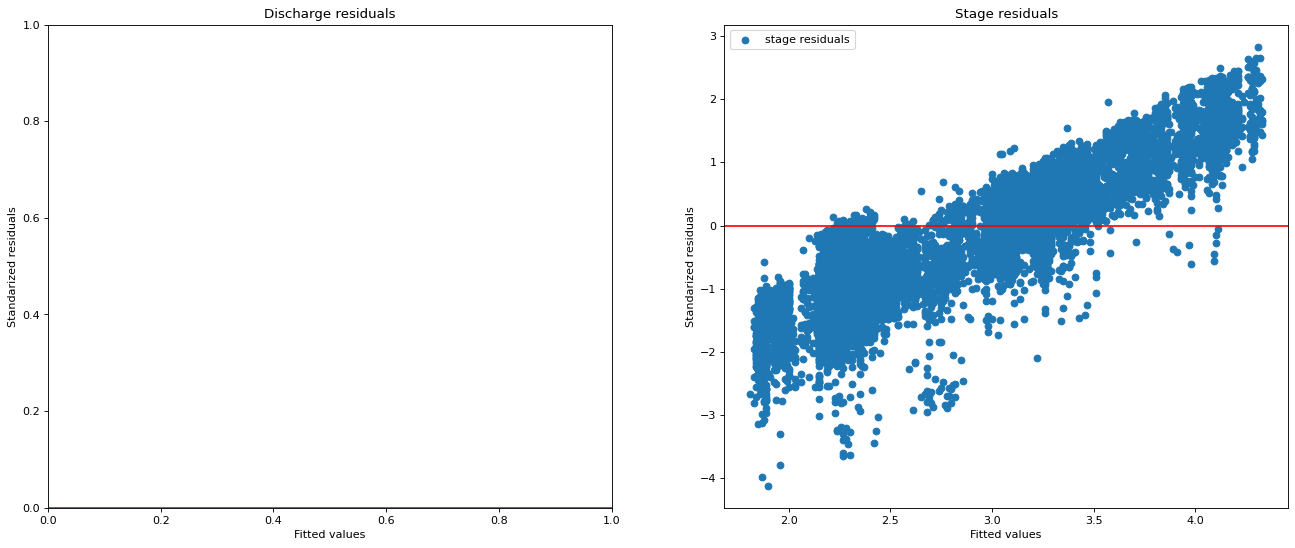

In [63]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = y_test
residual_stage = residuals

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

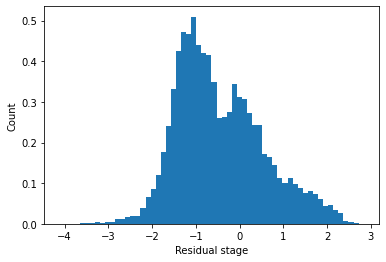

In [64]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

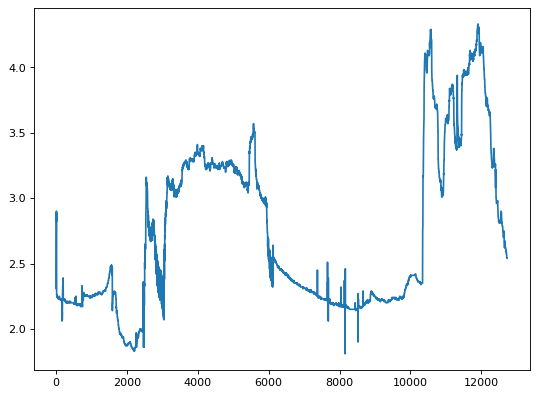

In [65]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(y_test)), y_test, label="Stage real")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


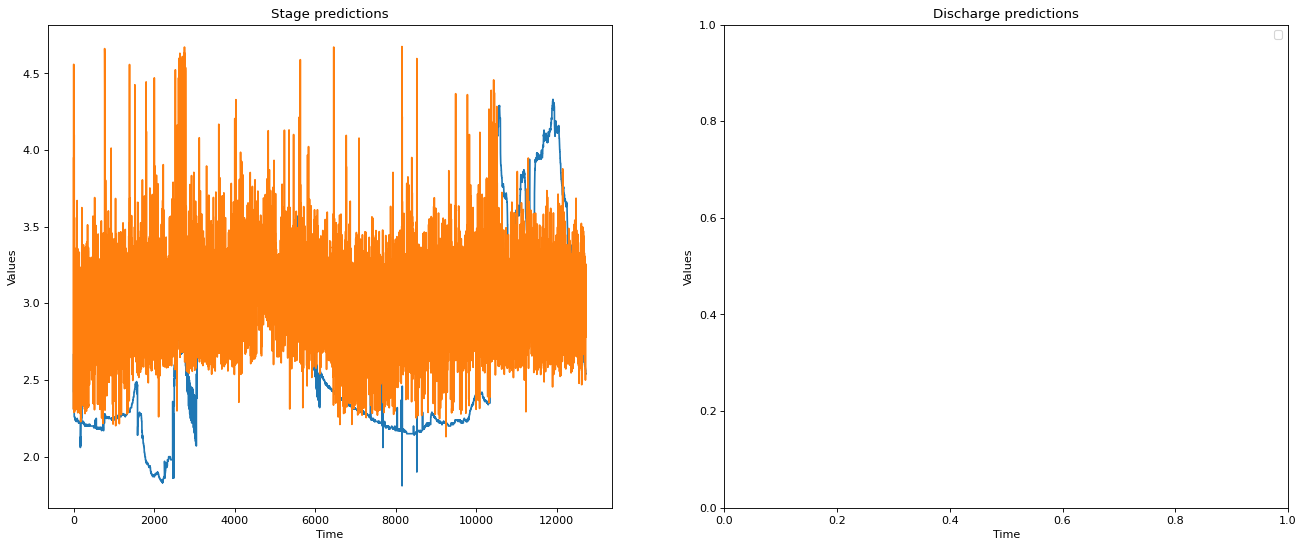

In [66]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

ax[0].legend()
ax[1].legend()
plt.show()